In [1]:
# Import the required libraries
import os
import torch
import numpy as np
import transformers
from transformers import AutoModelForSequenceClassification, GlueDataTrainingArguments, AutoTokenizer
import torchmetrics
import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from apx import ApproxEmbed, ApxSVD
from glue_score import GLUE_TASKS, make_model, Glue, plot

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
transformers.utils.logging.set_verbosity_error
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

epochs=5
lr=1e-5

saved_dict = torch.load('runs\8_8.pth')

runs=["compressed fixed", "compressed SVD"]#"normal", "compressed adaptive", 

cola compressed fixed


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

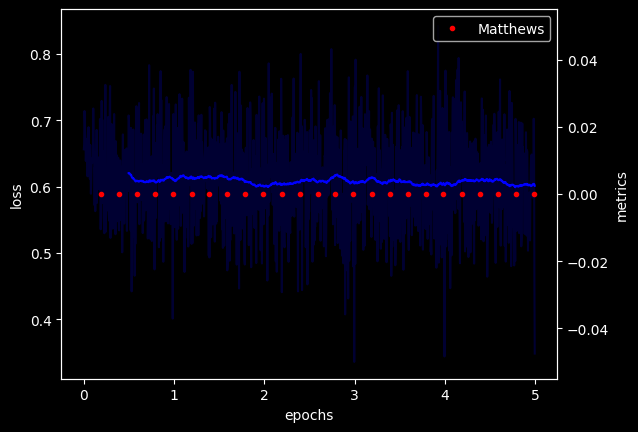

cola compressed SVD


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

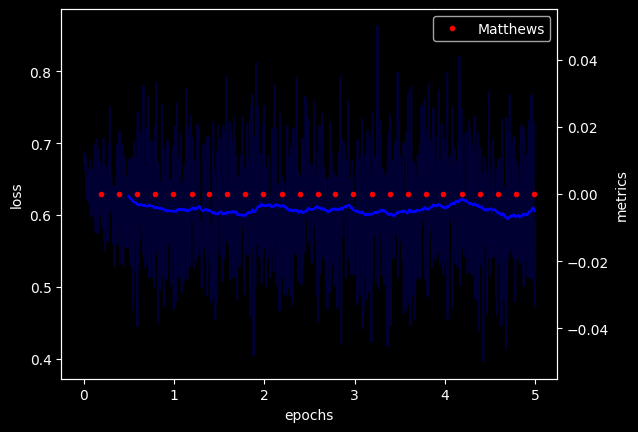

sst2 compressed fixed


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

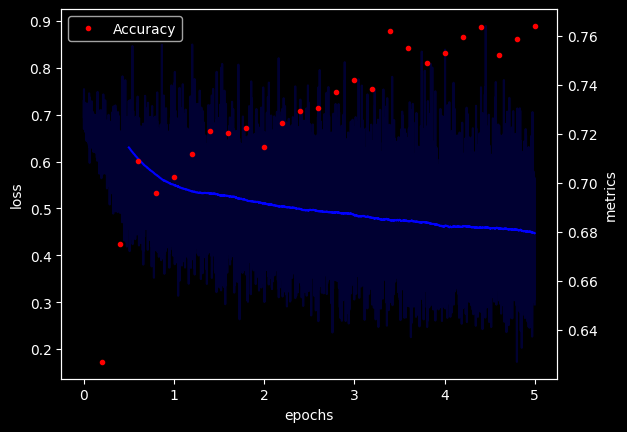

sst2 compressed SVD


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

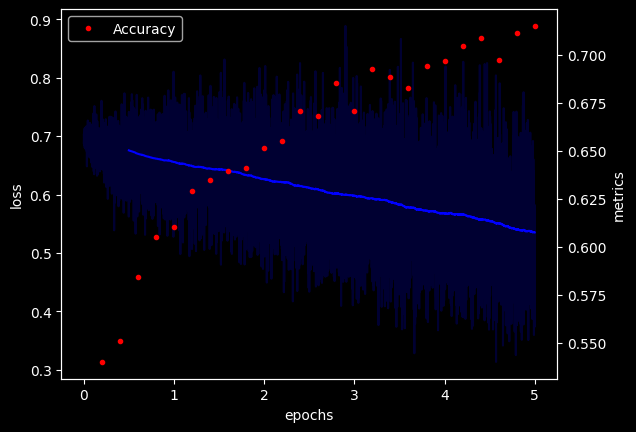

In [42]:
RESULTS={}
for task in list(GLUE_TASKS.keys())[:2]:
    results={}
    for run in runs:
        print(task,run)
        args=GLUE_TASKS[task]
        model=make_model('prajjwal1/bert-tiny',args)
        if run=="compressed adaptive":
            apx = ApproxEmbed(levels=saved_dict['level'],
                feature_dim=saved_dict['channel'],
                num_words=model.bert.embeddings.word_embeddings.weight.shape[0],
                output_dims=model.bert.embeddings.word_embeddings.weight.shape[1],
                )
            apx.load_state_dict(saved_dict['apx'])
            model.bert.embeddings.word_embeddings = apx.to('cuda')
        elif run=="compressed fixed":
            apx = ApproxEmbed(levels=saved_dict['level'],
                feature_dim=saved_dict['channel'],
                num_words=model.bert.embeddings.word_embeddings.weight.shape[0],
                output_dims=model.bert.embeddings.word_embeddings.weight.shape[1],
                )
            apx.load_state_dict(saved_dict['apx'])
            apx.fix_indices()
            model.bert.embeddings.word_embeddings = apx.to('cuda')
        elif run=="compressed SVD":
            apxSVD = ApxSVD(model.bert.embeddings.word_embeddings.weight, 5)
            model.bert.embeddings.word_embeddings = apxSVD.to('cuda')
        H,V = Glue(model, tokenizer, task, args, epochs=epochs, steps_validate=0.2)
        plot(H,V)
        results[run]={'history':H,'validation':V}
    RESULTS[task]=results

In [43]:
save_path='results/'
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

torch.save(RESULTS, save_path+'glue_results.pth')

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


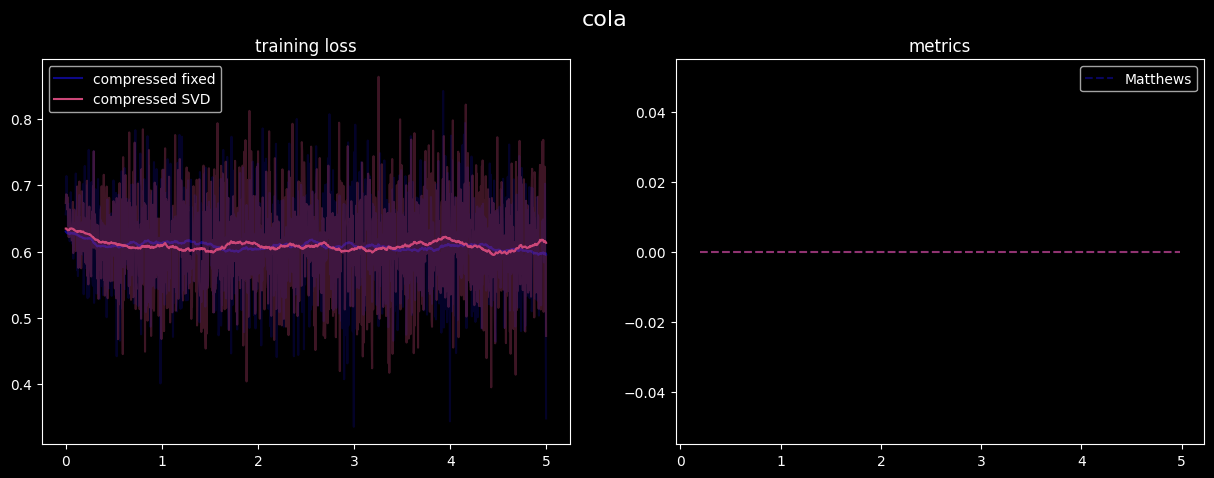

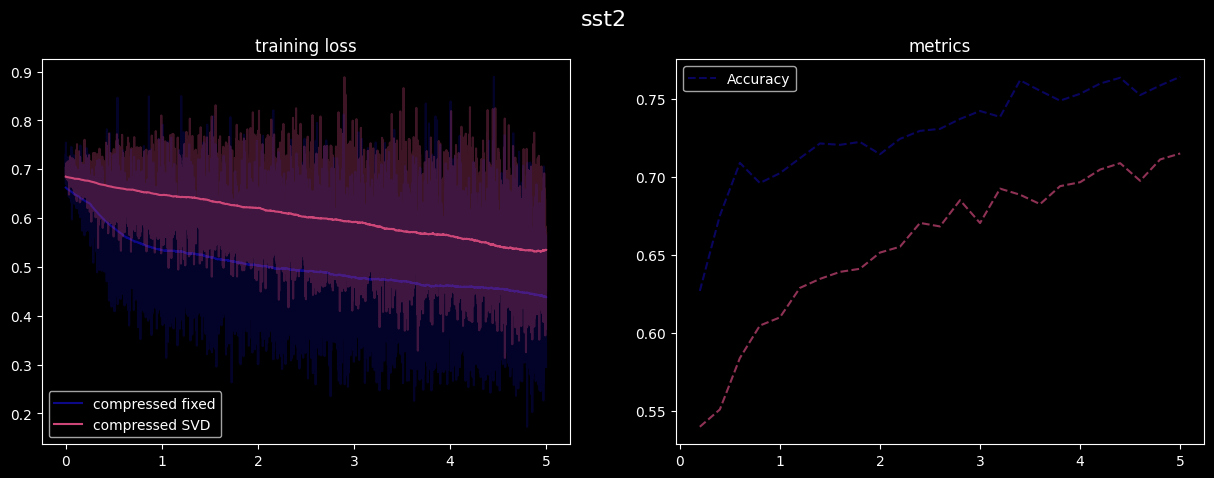

In [1]:
from glue_score import plot_results
import torch

run_dict=torch.load('results/glue_results.pth')
plot_results(run_dict)